In [298]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing import image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf



In [319]:
img_w = 400
img_h = 400

In [320]:
def load_reshape_img(imagePath):
    img  = load_img(imagePath).resize((img_w, img_h))
    imgArray = image.img_to_array(img)
    imgArray = np.reshape(imgArray, ((1,) + imgArray.shape))
    return imgArray, img

In [321]:
def deprocess_image(input_image):
    x = np.reshape(input_image, (img_w, img_h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

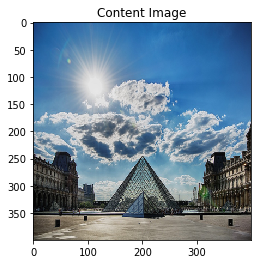

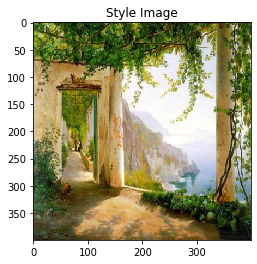

Content Image Shape :(1, 400, 400, 3)
Style Image Shape :(1, 400, 400, 3)


In [322]:
contentImgTest, contentImg = load_reshape_img("images/content1.jpg")
styleImgTest, styleImg = load_reshape_img("images/style3.jpg")

plt.imshow(contentImg)
plt.title("Content Image")
plt.show()
plt.imshow(styleImg)
plt.title("Style Image")
plt.show()


print("Content Image Shape :" + str(contentImgTest.shape) )
print("Style Image Shape :" + str(styleImgTest.shape) )

In [323]:
imputImgArray = np.random.rand(img_w,img_h, 3) * 255
inputImage = Image.fromarray(imputImgArray.astype('uint8')).convert('RGB')
inputImage.save("images/input.jpg")

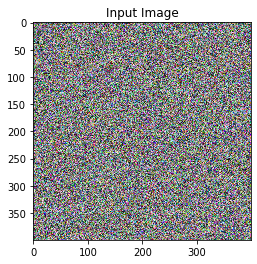

Input Image Shape :(1, 400, 400, 3)


In [324]:
inputImageTest, inputImg = load_reshape_img("images/input.jpg")

plt.imshow(inputImg)
plt.title("Input Image")
plt.show()
print("Input Image Shape :" + str(inputImageTest.shape) )


In [325]:
content_layers = [('block5_conv2', 0.025)]
style_layers = [('block1_conv1', .2),
                ('block2_conv1', .125),
                ('block3_conv1', 1.),
                ('block4_conv1', .3),
                ('block5_conv1', 1.)
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [326]:
def get_model():
    modelVGG = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)
    modelVGG.trainable = False
    model_layers = [modelVGG.get_layer(styleLayerName).output for styleLayerName, weight in style_layers]
    model_layers = model_layers + [modelVGG.get_layer(contentLayerName).output for contentLayerName, weight in content_layers]  
    model = tf.keras.Model(modelVGG.input, model_layers)
    return model

In [327]:
model = get_model()

In [328]:
contentImageArray, _ = load_reshape_img("images/content.jpg")
styleImgArray, _ = load_reshape_img("images/style3.jpg")
contentImageArray = tf.keras.applications.vgg19.preprocess_input(tf.convert_to_tensor(contentImageArray))
styleImgArray = tf.keras.applications.vgg19.preprocess_input(tf.convert_to_tensor(styleImgArray))
contentActivations = model(contentImageArray)
styleActivations = model(styleImgArray)
 


In [329]:
def compute_content_cost(contentActivation, targetActivation):
    m, n_w, n_h, n_c = targetActivation.get_shape().as_list()
    contentActivationUnrolled = tf.reshape(contentActivation, [m, n_w * n_h, n_c])
    targetActivationUnrolled =  tf.reshape(targetActivation, ((m, n_w * n_h, n_c)))
    content_cost = tf.math.reduce_sum(tf.square(tf.subtract(contentActivationUnrolled, targetActivationUnrolled)))
    return content_cost
    

In [330]:
def gram_matrix(activation):
    gramMatrixOfActivation = tf.matmul(activation, tf.transpose(activation))
    return gramMatrixOfActivation

In [331]:
def compute_layer_style_cost(styleActivation, targetActivation):
    m, n_w, n_h, n_c = targetActivation.get_shape().as_list()
    styleActivationUnrolled = tf.transpose(tf.reshape(styleActivation, ((n_w * n_h, n_c))), perm=[1, 0])
    targetActivationUnrolled = tf.transpose(tf.reshape(targetActivation, ((n_w * n_h, n_c))), perm=[1, 0])
    styleGramMatrix = gram_matrix(styleActivationUnrolled)
    targetGramMatrix = gram_matrix(targetActivationUnrolled)
    style_layer_cost =  tf.math.reduce_sum(tf.square(tf.subtract(styleGramMatrix, targetGramMatrix)))/(4 * (n_c * n_c) * (n_w * n_h) * (n_w * n_h))
    return style_layer_cost

In [332]:
def compute_total_content_cost(inputActivations):
    contentOnlyActivations = contentActivations[num_style_layers:]
    inputContentOnlyActivations = inputActivations[num_style_layers:]
    content_cost = 0.
    for layer_index in range(len(inputContentOnlyActivations)):
         content_cost = content_cost + content_layers[layer_index][1] * compute_content_cost(contentOnlyActivations[layer_index], inputContentOnlyActivations[layer_index])
    return content_cost

In [333]:
def compute_total_style_cost(inputActivations):
    styleOnlyActivations = styleActivations[:num_style_layers]
    inputContentOnlyActivations = inputActivations[:num_style_layers]
    style_cost = 0.
    for layer_index in range(len(inputContentOnlyActivations)):
         style_cost = style_cost + style_layers[layer_index][1] * compute_layer_style_cost(styleOnlyActivations[layer_index], inputContentOnlyActivations[layer_index])
    return style_cost

In [334]:
def compute_total_cost(cfg, alpha=10, beta=40):
    inputActivations = model(cfg['init_image'])
    totalContentCost = compute_total_content_cost(inputActivations)
    totalStyleCost = compute_total_style_cost(inputActivations)
    totalCost = alpha * totalContentCost + beta * totalStyleCost
    
    return totalCost, totalContentCost, totalStyleCost

In [335]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_total_cost(cfg)
    return tape.gradient(all_loss[0], cfg['init_image']), all_loss

In [336]:
def model_nn(input_image_path, num_iterations = 1001):
    inputImageArray, _ = load_reshape_img(input_image_path)
    inputImageArray = tf.keras.applications.vgg19.preprocess_input(inputImageArray)
    inputImageArray = tf.Variable(tf.convert_to_tensor(inputImageArray), trainable=True, dtype=tf.float32)
    iter_count = 1
   
    
    cfg = {
      'init_image': inputImageArray,
    }
    optimizer = tf.keras.optimizers.Adam(10.0)
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        optimizer.apply_gradients([(grads, inputImageArray)])
         # Print every 20 iteration.
        if i%50 == 0:
            print("total Loss at Iteration :" +str(i) + str(all_loss[0]))
            print("total content Loss at Iteration :" +str(i) + str(all_loss[1]))
            print("total style Loss at Iteration :" +str(i) + str(all_loss[2]))
            # Display intermediate images
            # Use the .numpy() method to get the concrete numpy array
            img = inputImageArray.numpy()
            plot_img = deprocess_image(img)
            plot_img = Image.fromarray(plot_img)
            plot_img.save("images/inputB"+str(iter_count)+".jpg")
            iter_count = iter_count + 1
    return inputImageArray
    

In [337]:
model_nn("images/content1.jpg")

total Loss at Iteration :0tf.Tensor(208783180000.0, shape=(), dtype=float32)
total content Loss at Iteration :0tf.Tensor(73855010.0, shape=(), dtype=float32)
total style Loss at Iteration :0tf.Tensor(5201115600.0, shape=(), dtype=float32)
total Loss at Iteration :50tf.Tensor(2649434400.0, shape=(), dtype=float32)
total content Loss at Iteration :50tf.Tensor(67444420.0, shape=(), dtype=float32)
total style Loss at Iteration :50tf.Tensor(49374756.0, shape=(), dtype=float32)
total Loss at Iteration :100tf.Tensor(1492463100.0, shape=(), dtype=float32)
total content Loss at Iteration :100tf.Tensor(64642796.0, shape=(), dtype=float32)
total style Loss at Iteration :100tf.Tensor(21150880.0, shape=(), dtype=float32)
total Loss at Iteration :150tf.Tensor(1228056800.0, shape=(), dtype=float32)
total content Loss at Iteration :150tf.Tensor(62403252.0, shape=(), dtype=float32)
total style Loss at Iteration :150tf.Tensor(15100609.0, shape=(), dtype=float32)
total Loss at Iteration :200tf.Tensor(135

<tf.Variable 'Variable:0' shape=(1, 400, 400, 3) dtype=float32, numpy=
array([[[[  82.30687   ,    1.587978  ,  -11.414953  ],
         [  59.643852  ,  -80.10669   ,  -58.71528   ],
         [ -13.907413  , -104.17266   , -105.17167   ],
         ...,
         [  17.113169  ,  -74.24244   , -118.74818   ],
         [  71.48814   ,   37.59186   ,  -39.78103   ],
         [ 181.2891    ,   80.12472   ,   12.812275  ]],

        [[ -11.157033  , -114.017265  , -112.70212   ],
         [ -35.796875  , -106.803345  , -101.94816   ],
         [ -31.811338  ,  -83.872574  ,  -83.4099    ],
         ...,
         [-113.612076  , -126.15413   , -167.61017   ],
         [-127.47628   , -102.62284   , -162.07639   ],
         [  41.73443   ,  -32.134586  ,  -77.9985    ]],

        [[ -40.173775  ,  -96.62526   , -113.164444  ],
         [ -30.919193  ,  -68.178764  ,  -44.524734  ],
         [ -28.526842  ,  -66.19033   ,  -58.220825  ],
         ...,
         [ -88.3407    ,  -50.185474  ,  -6